In [1]:
import yfinance as yf
import numpy as np
import pandas as pd


stock_data=yf.Ticker('^GSPC').history(period="max")
stock_data.dropna(inplace=True)

In [2]:
period=20
stdev=2

stock_data['rolling_mean']=stock_data['Close'].rolling(window=period).mean()
stock_data['rolling_std']=stock_data['Close'].rolling(window=period).std()

datelims=['2022-01-01','2023-12-31']
_stock_data=stock_data.loc[datelims[0]:datelims[1]]
percent_bandwidth=(_stock_data['Close']-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))/((_stock_data['rolling_mean']+2*_stock_data['rolling_std'])-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))

bandwidth=((_stock_data['rolling_mean']+2*_stock_data['rolling_std'])-(_stock_data['rolling_mean']-2*_stock_data['rolling_std']))/_stock_data['rolling_mean']


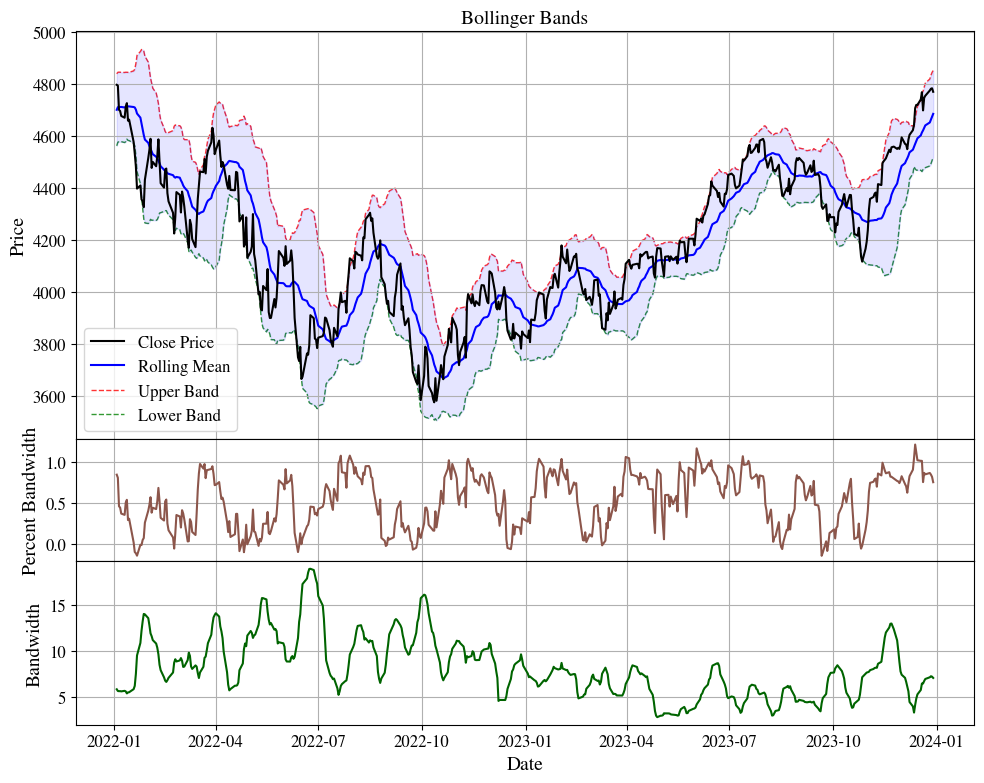

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[1, 0.3, 0.4], hspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)


ax1.plot(_stock_data['Close'],label='Close Price',color='black',zorder=5)
ax1.plot(_stock_data['rolling_mean'],label='Rolling Mean',color='blue',zorder=2)
ax1.plot(_stock_data['rolling_mean']+stdev*_stock_data['rolling_std'],label='Upper Band',color='red',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.plot(_stock_data['rolling_mean']-stdev*_stock_data['rolling_std'],label='Lower Band',color='green',linestyle='--',linewidth=1,alpha=.8,zorder=0)
ax1.fill_between(_stock_data.index,_stock_data['rolling_mean']+stdev*_stock_data['rolling_std'],_stock_data['rolling_mean']-stdev*_stock_data['rolling_std'],color='blue',alpha=.1)
ax3.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid()
ax1.legend()
ax1.set_title('Bollinger Bands')


ax2.plot(percent_bandwidth,label='Percent Bandwidth',color='tab:brown',zorder=5)
ax2.set_ylabel('Percent Bandwidth')
ax2.grid()
#ax2.legend()

ax3.plot(bandwidth*100,label='Bandwidth',color='darkgreen',zorder=2)
ax3.set_ylabel('Bandwidth')
ax3.grid()
#ax3.legend()

plt.tight_layout()
plt.savefig('figures/bollinger_bands.png',dpi=300,bbox_inches='tight')
plt.show()

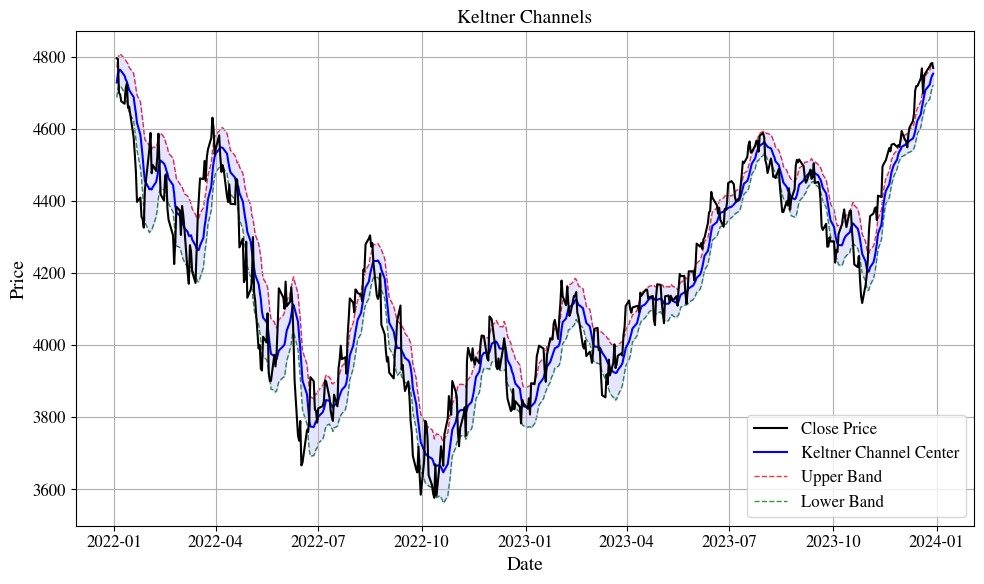

In [7]:
keltner_period=10
stock_data['typical_price']=(stock_data['High']+stock_data['Low']+stock_data['Close'])/3
stock_data['keltner_channel_center']=stock_data['typical_price'].rolling(window=keltner_period).mean()
stock_data['range']=stock_data['High']-stock_data['Low']
stock_data['keltner_channel_width']=stock_data['range'].rolling(window=keltner_period).mean()


datelims=['2022-01-01','2023-12-31']
_stock_data=stock_data.loc[datelims[0]:datelims[1]]

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



fig = plt.figure(figsize=(10, 6))

plt.plot(_stock_data['Close'],label='Close Price',color='black',zorder=5)
plt.plot(_stock_data['keltner_channel_center'],label='Keltner Channel Center',color='blue',zorder=2)
plt.plot(_stock_data['keltner_channel_center']+_stock_data['keltner_channel_width'],label='Upper Band',color='red',linestyle='--',linewidth=1,alpha=.8,zorder=0)
plt.plot(_stock_data['keltner_channel_center']-_stock_data['keltner_channel_width'],label='Lower Band',color='green',linestyle='--',linewidth=1,alpha=.8,zorder=0)
plt.fill_between(_stock_data.index,_stock_data['keltner_channel_center']+_stock_data['keltner_channel_width'],_stock_data['keltner_channel_center']-_stock_data['keltner_channel_width'],color='blue',alpha=.1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.title('Keltner Channels')
plt.tight_layout()
plt.savefig('figures/keltner_channels.png',dpi=300,bbox_inches='tight')
plt.show()

In [16]:
# Buy when close price crosses above upper band
# Sell when close price crosses below lower band

buy_signals = _stock_data[_stock_data['Close'] > (_stock_data['keltner_channel_center'] + _stock_data['keltner_channel_width'])]
sell_signals = _stock_data[_stock_data['Close'] < (_stock_data['keltner_channel_center'] - _stock_data['keltner_channel_width'])]

signals = pd.concat([buy_signals.assign(signal='buy'),
                     sell_signals.assign(signal='sell')]).sort_index()

first_buy = signals.loc[signals.signal == 'buy'].index.min()
last_sell = signals.loc[signals.signal == 'sell'].index.max()
signals = signals[(signals.index >= first_buy) & (signals.index <= last_sell)]
signals = signals[signals.signal.ne(signals.signal.shift())]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_mean,rolling_std,typical_price,keltner_channel_center,range,keltner_channel_width,signal
Date,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,4778.140137,4796.640137,4758.169922,4796.560059,3831020000,0.0,0.0,4700.649536,69.129553,4783.790039,4729.306722,38.470215,41.731055,buy
2022-01-05 00:00:00-05:00,4787.990234,4797.700195,4699.439941,4700.580078,4887960000,0.0,0.0,4711.434546,66.898027,4732.573405,4763.093392,98.260254,43.514111,sell
2022-02-02 00:00:00-05:00,4566.390137,4595.310059,4544.319824,4589.379883,4481580000,0.0,0.0,4551.106445,135.586463,4576.336589,4434.700993,50.990234,117.072119,buy
2022-02-11 00:00:00-05:00,4506.270020,4526.330078,4401.410156,4418.640137,5251500000,0.0,0.0,4483.650488,89.065750,4448.793457,4512.726335,124.919922,77.033984,sell
2022-03-16 00:00:00-04:00,4288.140137,4358.899902,4251.990234,4357.859863,6309750000,0.0,0.0,4303.688477,82.256792,4322.916667,4264.053320,106.909668,87.579785,buy


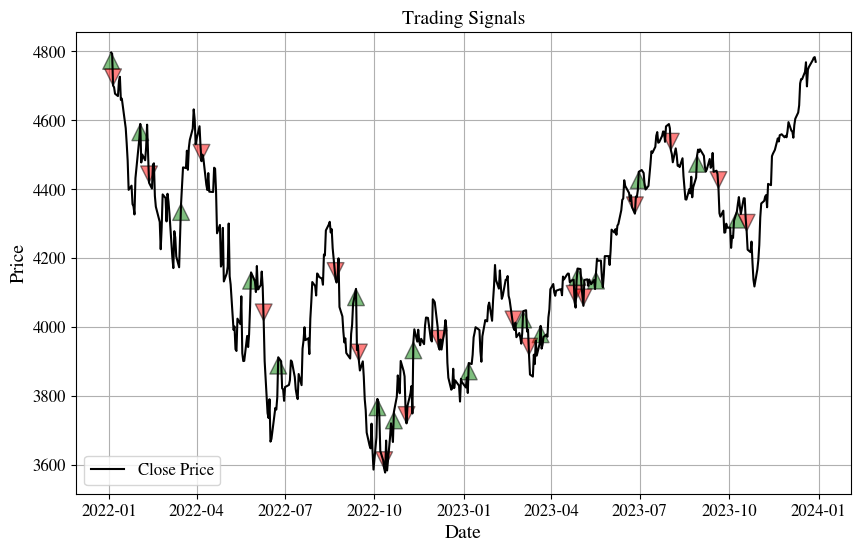

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



fig = plt.figure(figsize=(10, 6))
plt.plot(_stock_data['Close'],label='Close Price',color='black',zorder=5)
for idx in signals[signals['signal']=='buy'].index:
    plt.annotate('', xy=(idx, signals.loc[idx, 'Close']), fontsize=8,
                xytext=(idx, signals.loc[idx, 'Close']-15),
                arrowprops=dict(facecolor='green', shrink=0.01,alpha=0.5),
                bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.5))

for idx in signals[signals['signal']=='sell'].index:
    plt.annotate('', xy=(idx, signals.loc[idx, 'Close']), fontsize=8,
                xytext=(idx, signals.loc[idx, 'Close']+15),
                arrowprops=dict(facecolor='red', shrink=0.01,alpha=0.5),
                bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5))    

plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.title('Trading Signals')
plt.show()

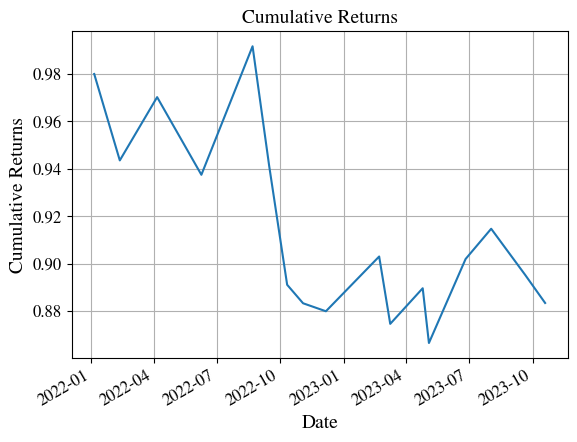

In [21]:
# Calculate the returns
signals['returns'] = signals['Close'].pct_change()
#signals['strategy'] = signals['signal'].map({'buy': signals['returns'], 'sell': -signals['returns']})
returns=signals[signals['signal']=='sell']['returns']
cumulative_returns=(1+returns).cumprod()
cumulative_returns.plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.title('Cumulative Returns')
plt.show()